<a href="https://colab.research.google.com/github/shweta-aiml/100daysofcode/blob/master/hair_segmentation_using_u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References https://www.kaggle.com/rahuldshetty/hair-segmentation-using-u-net/comments

Thanks to people who are doing such amazing work and sharing !!!


In [1]:
!pip install tensorflow

In [2]:
import numpy as np 
import pandas as pd 
import os
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from skimage import io

x_path = '/content/drive/My Drive/FigaroDataSet/Figaro1k/Original/Training/'
y_path = '/content/drive/My Drive/FigaroDataSet/Figaro1k/GT/Training/'
x_paths = os.listdir(x_path)
y_paths = os.listdir(y_path)
print("Count X:",len(x_paths))
print("Count Y:",len(y_paths))

Count X: 840
Count Y: 855


In [5]:
x_paths[0],y_paths[0]

('Frame00004-org.jpg', 'Frame00001-gt.pbm')

In [6]:
images,masks = [],[]
size = min(len(x_paths),len(y_paths))
for i in range(size):
  file = x_paths[i].replace('-org.jpg','')
  img_path = file + '-org.jpg'
  mask_path = file + '-gt.pbm'
  if img_path in x_paths and mask_path in y_paths:
    images.append( io.imread(x_path + img_path,plugin='matplotlib',as_gray = True) )
    masks.append( io.imread(y_path + mask_path,plugin='matplotlib',as_gray = True))
print("Actual data size:",len(images),len(masks))

Actual data size: 839 839


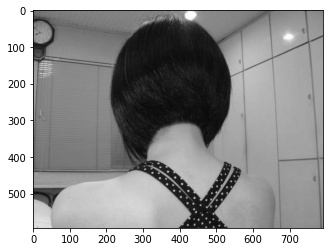

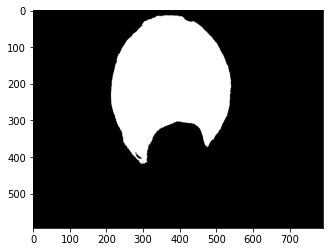

In [7]:
def displayImage(img):
    plt.imshow(img,cmap='gray')
    plt.show()

idx = 50

img = images[idx]
displayImage(img)

img = masks[idx]
displayImage(img)

In [8]:
from skimage.transform import resize
np_images = np.zeros((size,224,224,1))
np_masks = np.zeros((size,224,224,1))

print("shape to be resized",np_images.shape)



shape to be resized (840, 224, 224, 1)


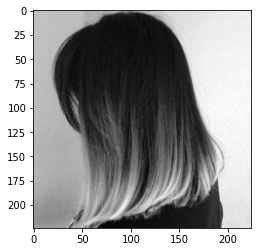

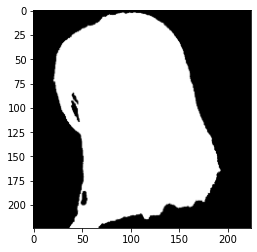

In [9]:
for i in range(size -1):
    img = images[i]
    msk = masks[i]
    np_images[i] = resize(img,(224,224)).reshape((-1,224,224,1))
    np_masks[i] = resize(msk,(224,224)).reshape((-1,224,224,1))

sample = np_images[0].reshape((224,224))
displayImage(sample)

sample = np_masks[0].reshape((224,224))
displayImage(sample)

In [0]:
#U-UNET
inputs = Input((224, 224, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)

In [0]:
up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)



In [12]:
model = Model(inputs=[inputs], outputs=[conv10])

#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [20]:
epochs = 40
history = model.fit(np_images,np_masks,validation_split=0.05,epochs=epochs,batch_size=64,)
model.save('/content/sample_data/model.h5')

Train on 798 samples, validate on 42 samples
Epoch 1/40
798/798 [==============================] - 21s 26ms/step - loss: 0.1046 - acc: 0.8207 - val_loss: 0.1139 - val_acc: 0.8002
Epoch 2/40
798/798 [==============================] - 21s 26ms/step - loss: 0.0952 - acc: 0.8340 - val_loss: 0.1033 - val_acc: 0.8133
Epoch 3/40
798/798 [==============================] - 21s 26ms/step - loss: 0.0927 - acc: 0.8388 - val_loss: 0.0941 - val_acc: 0.8278
Epoch 4/40
798/798 [==============================] - 21s 26ms/step - loss: 0.0830 - acc: 0.8522 - val_loss: 0.0938 - val_acc: 0.8248
Epoch 5/40
798/798 [==============================] - 21s 26ms/step - loss: 0.0808 - acc: 0.8548 - val_loss: 0.0891 - val_acc: 0.8347
Epoch 6/40
798/798 [==============================] - 21s 26ms/step - loss: 0.0739 - acc: 0.8650 - val_loss: 0.0885 - val_acc: 0.8350
Epoch 7/40
798/798 [==============================] - 21s 26ms/step - loss: 0.0686 - acc: 0.8710 - val_loss: 0.0806 - val_acc: 0.8425
Epoch 8/40
798/79

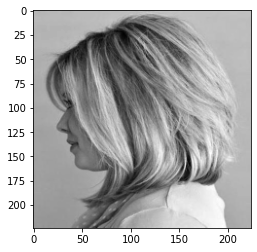

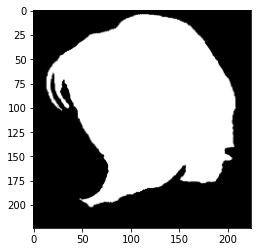

(224, 224, 1)


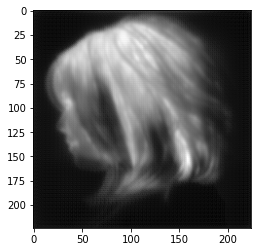

In [14]:
def predict(image):
    return model.predict(np.asarray([image]) ).reshape((224,224))
idx = 29
img = np_images[idx]
real = np_masks[idx]

displayImage(img.reshape((224,224)))
displayImage(real.reshape((224,224)))

print(img.shape)
pred = predict(img)
displayImage(pred)




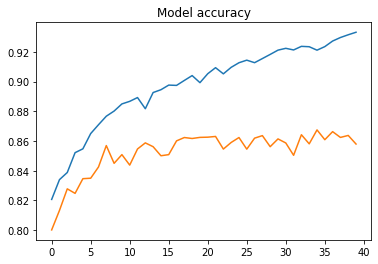

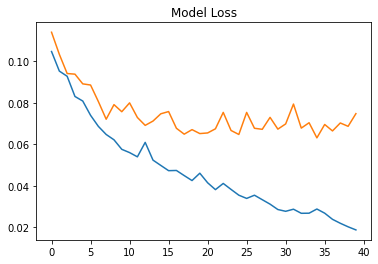

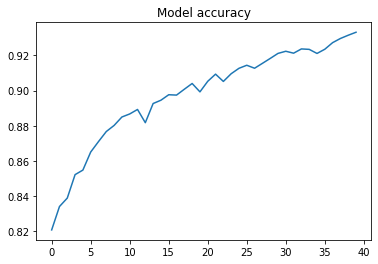

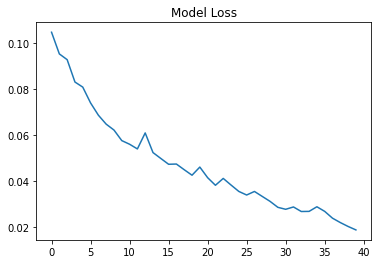

In [21]:
h = history
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.show()

plt.plot(h.history['acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

In [0]:
np_test_images = np.zeros((size,224,224,1))
np_test_masks = np.zeros((size,224,224,1))

for i in range(size):
    np_test_images[i] = resize(images[i],(224,224)).reshape((224,224,1))
    np_test_masks[i] = resize(masks[i],(224,224)).reshape((224,224,1))

    test_img = np_test_images[i].reshape((1,224,224,1))
    #displayImage(test_img)
    print(test_img.shape)
          
    test_msk = np_test_masks[i].reshape((1,224,224,1))
    #displayImage(sample)

    print('\n# Evaluate on test data')
    results = model.evaluate(test_img, test_msk, batch_size=128)
    print('test loss, test acc:', results)  

In [0]:
print('\n# Evaluate on test data')
results = model.evaluate(np_test_images, np_test_masks, batch_size=128)
print('test loss, test acc:', results)

In [0]:
model.save_weights('/content/modelwithweights.h5', overwrite=True)

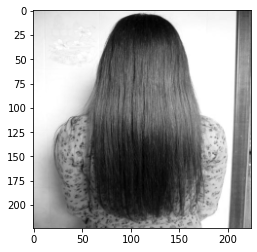

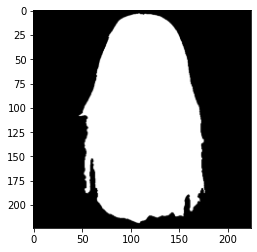

(224, 224, 1)


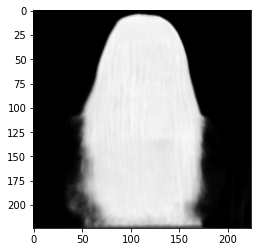

In [29]:
idx = 3
img = np_images[idx]
real = np_masks[idx]

displayImage(img.reshape((224,224)))
displayImage(real.reshape((224,224)))

print(img.shape)
pred = predict(img)
displayImage(pred)





In [0]:
sample_images = [
                 '/content/sharukh_hair1.jpg','/content/shahrukh_hair_2.jpeg'
                 ,'/content/im1.jpeg','/content/im2.jpeg','/content/im3.jpg','/content/im4.jpg']


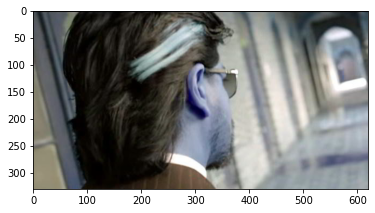

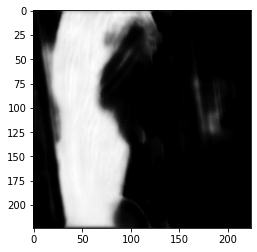

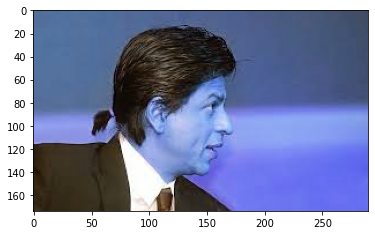

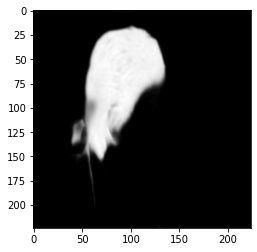

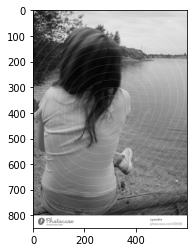

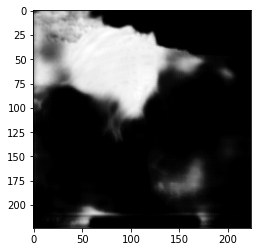

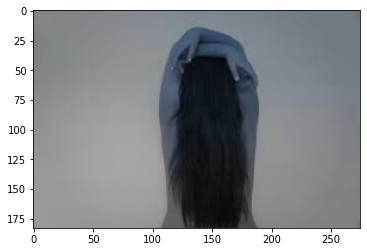

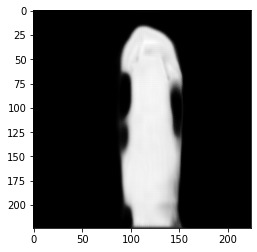

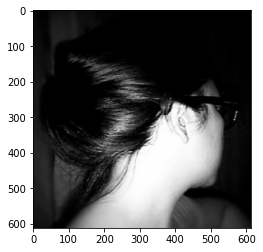

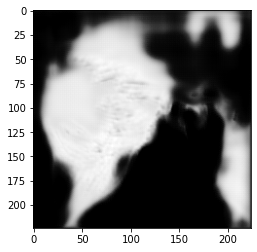

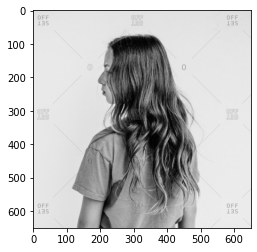

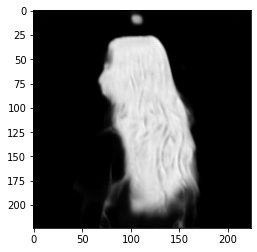

In [44]:
import cv2
for i in range(len(sample_images)):
  img_sample = cv2.imread(sample_images[i])
  plt.imshow(img_sample)
  plt.show()
  img_sample = cv2.resize(img_sample,(224,224))
  img_sample.flatten()/224
  img_sample = resize(img_sample,(224,224,1))
  
  pred = predict(img_sample)
  displayImage(pred)